In [374]:
def traj_to_dist2(traji,bins=20,random_rotation=0,ndim=2):
    

    traji_delta = traji[1:,::]-traji[:-1,::] 
    
    avoid = np.isnan(traji_delta) 

    newtraj =  (traji_delta-np.mean(traji_delta[~avoid[::,0]],axis=0))

    dist = np.sqrt( np.sum((traji_delta)**2,axis=1))
    
    mdist = np.mean(dist)
    
    normed= [copy.deepcopy(dist),copy.deepcopy(dist)]

    #Tangential vector
    for i in range(ndim):
        normed.append((traji_delta[::,i])/dist)
    #Real dx,dy,dz
    for i in range(ndim):
        normed.append((traji_delta[::,i])/mdist)

    normed.append([ len(dist)/100. for i in range(len(dist))])
    
    
    normed = np.array(normed).T
    
    
    normed[::,0] = normed[::,0]-np.mean(normed[::,0])
    normed[::,0] /= np.std(normed[::,0])
    normed[::,1] /=  np.std(normed[::,1])
    
    #Zero = normalized - mean
    #One = normalized
    
    normed[np.isnan(normed)] = 0
    
    return traji-np.mean(traji[~np.isnan(traji) ],axis=0) ,normed

if __name__ == "__main__":
    traj = np.random.normal(size=(100,2))
    traj[0,1] = np.nan
    traj2,normed = traj_to_dist2(traj,ndim=2)
    print normed.shape

(99, 7)


In [120]:
from numpy import mean,cov,cumsum,dot,linalg,array,rank
from numpy import cross, eye, dot
from scipy.linalg import expm3, norm

def M(axis, theta):
    return expm3(cross(eye(3), axis/norm(axis)*theta))


def plot_traj(X,label=[],random_sin=[],toplot=True):
    colors = {0:"b",1:"g",2:"r",3:"k"}

    for i,(d,t) in enumerate(X):
       
        plot(X[i:i+2,0],X[i:i+2:,1],color=colors[label[i]])
        
def random_rot(traj,alpha=None,ndim=2,axis=[],centered=True):
    
    if ndim == 2:
        if alpha is None:
            alpha = 2*3.14*np.random.random()
        if axis == []:
            axis = [[np.cos(-alpha),np.cos(-alpha+3.14/2)],
                   [np.sin(-alpha),np.sin(-alpha+3.14/2)]]

        axis=np.array(axis)
        
    if ndim == 3:
        if alpha is None:
            alpha = 3.14*np.random.random()
        if axis == []:
            axis = np.random.random(3)
            
        axis = M(axis,alpha)
        
        #print axis
    
    #print axis.shape
    if centered:
        newtraj =  (traj-mean(traj.T,axis=1)).T 
    else:
        newtraj =  traj.T 

    return dot(axis.T,newtraj).T

#print random_rot(np.zeros((10,3)),0,ndim=3)

In [244]:
colors = {0:"b",1:"g",2:"r",3:"k",4:"y",5:"c",6:"m"}
import colorsys
import numpy as np
try: 
    import pylab as plt
except:
    pass
N = 15
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)

colors= dict(colors.items() + {i+7:c for i,c in enumerate( RGB_tuples[::3]) }.items())

#print colors
def plot_label(traj,seq,remove6=None,linewidth=3,markersize=5,k=None):
    
    #colors
    #colors = {0:"b",1:"g",2:"r",3:"k",4:"y",5:"c",6:"m",7:"b",8:"g",9:"r"}
    #print traj.shape,seq.shap
    init_seq = seq[0]
    i = 0 
    start = 0
    while i < len(traj)-1:
        start = i
        init_seq = seq[i]
        while i < len(traj)-1 and seq[i] == init_seq:
            i += 1
        #print start,i,traj[start:i+1,0]
        #print 
        if remove6:
            if init_seq  == remove6:
                continue
        if k is None:
            plt.plot(traj[start:i+1,0],traj[start:i+1,1],"-o",color=colors[init_seq],
                 linewidth=linewidth,markersize=markersize)
        if k in [0,1]:
            plt.plot(range(start,i+1),traj[start:i+1,k],"-o",color=colors[init_seq],
                 linewidth=linewidth,markersize=markersize)


In [246]:
try: 
    from sklearn.metrics import confusion_matrix


    def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues,labels=[],rotation=45):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(cm.shape[0])
        #print len(labels),cm.shape[0]

        assert len(labels) == cm.shape[0]
        plt.xticks(tick_marks, labels, rotation=rotation)
        plt.yticks(tick_marks, labels,rotation=0)
        #plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
except:
    pass


In [247]:

def get_statistiques_hmm(Y_tests,Y_test_cat,root="",zone=range(500)):
    hmm = []
    SVM = []
    Class_HMM = []
    

    mv = []
    mv_HMM = []
    for i in zone:

        PrM,states,labels,possible,possible2,t = get_step_class(root+"/res%i.mat"%i)

        init = np.argmax(Y_tests[i],axis=1)

        l=len(Y_tests[i])-1
        #print l

        if possible != []:
            #print init
            #print possible
            diff = [ np.sum(init[:l] != possible[k][:l]) for k in range(len(possible))]
            #print diff
            states = possible[np.argmin(diff)]
            #print i,diff
            #print i,len(possible),labels
            """ 
            diff = [ np.sum(init[:l] != possible2[k][:l]) for k in range(12)]
            states = possible2[np.argmin(diff)]
            """



        Class_HMM.append(states[:l])
        hmm.append(np.sum(init[:l] != states[:l])*100./l)

        mv.extend(init[:l])
        mv_HMM.extend(states[:l])

    hmm = np.array(hmm)
  

    mvc = []
    mvc_HMM = []


    HMM = []
    GT = []
    misp_HMM = []
    correct_HMM = []

    for i in zone:

        PrM,_,labels,possible,possible2,_ = get_step_class(root+"/res%i.mat"%i)

        cat = np.argmax(Y_test_cat[i])

        catHMM = np.argmax(PrM)

        HMM.append(catHMM)
        GT.append(cat)

        mvc.append(cat)
        mvc_HMM.append(catHMM)


        if cat != catHMM:
            misp_HMM.append(PrM[cat])
        else:
            correct_HMM.append(PrM[cat])

    hmm = np.array(hmm)

    GT = np.array(GT)

    return [np.sum(np.array(mv) != np.array(mv_HMM)) *100. / len(mv), len(mv) , confusion_matrix(mv,mv_HMM), \
            np.sum(GT != mvc_HMM) *100./len(GT) ,len(GT), confusion_matrix(mvc,mvc_HMM)]

In [748]:


def get_statistiques(Y_tests,Y_test_cat,pred_RNN,pred_RNN_cat,fight=False,sub=True):

    RNN = []

    Class_RNN = []

    zone = range(0,len(pred_RNN))
    mv = []
    mv_RNN = []

    for i in zone:



        init = np.argmax(Y_tests[i],axis=1)

        l=len(Y_tests[i])-1
        #print l


        classi_RNN = np.argmax(pred_RNN[i][:l],axis=1)


        delta_RNN = np.sum(classi_RNN != init[:l]) 
        
        perm = np.array([[0, 1, 2, 3, 4, 5, 6],
             [0, 1, 2, 4, 5, 3, 6],
             [0, 1, 2, 5, 4, 3, 6],
             [0, 1, 2, 3, 5, 4, 6],
             [0, 1, 2, 4, 3, 5, 6],
             [0, 1, 2, 5, 3, 4, 6]],dtype=np.int)

        if sub:
            perm = np.array([[0, 1, 2, 3, 4, 5, 6]+range(7,10),
                         [0, 1, 2, 4, 5, 3, 6]+range(7,10),
                         [0, 1, 2, 5, 4, 3, 6]+range(7,10),
                         [0, 1, 2, 3, 5, 4, 6]+range(7,10),
                         [0, 1, 2, 4, 3, 5, 6]+range(7,10),
                         [0, 1, 2, 5, 3, 4, 6]+range(7,10)],dtype=np.int)
        deltas = []
        for permutation in perm:
            classi_RNN = clean(pred_RNN[i][:l,permutation],np.argmax(pred_RNN_cat[i]),fight=fight,sub=sub)

            deltas.append(np.sum(classi_RNN != init[:l]) )

        best = np.argmin(deltas)
        classi_RNN = clean(pred_RNN[i][:l,perm[best]],np.argmax(pred_RNN_cat[i]),fight=fight,sub=sub)

        Class_RNN.append(classi_RNN)
        RNN.append(np.sum(init[:l] != classi_RNN[:l])*100./l)

        mv.extend(init[:l])
        mv_RNN.extend(classi_RNN[:l])

    RNN = np.array(RNN)

    mvc = []
    mvc_RNN = []


    RNN = []
    GT = []
    for i in zone:


        cat = np.argmax(Y_test_cat[i])

        catRNN = np.argmax(pred_RNN_cat[i])


        RNN.append(catRNN)
        GT.append(cat)

        mvc.append(cat)
        mvc_RNN.append(catRNN)

    RNN = np.array(RNN)
    GT = np.array(GT)

    #print range(pred_RNN_cat[0].shape[1])
    return np.sum(np.array(mv) != np.array(mv_RNN)) *100. / len(mv), len(mv) , confusion_matrix(mv,mv_RNN), \
            np.sum(GT != RNN) *100./len(RNN) ,len(RNN), confusion_matrix(mvc,mvc_RNN,labels=range(pred_RNN_cat[0].shape[1]))


In [7]:
from prePostTools import traj_to_dist,get_parameters

In [8]:
#colors = {0:"b",1:"g",2:"r",3:"k",4:"y",5:"c",6:"m"}

def plot_by_class(traj,seq):
    #global colors
    #colors = {0:"b",1:"g",2:"r",3:"k",4:"y",5:"c",6:"m"}
    #print traj.shape,seq.shap
    init_seq = seq[0]
    i = 0 
    start = 0
    
    delta = traj[1:]-traj[:-1]
    
    for i in range(9):
        c = np.array(seq) == i
        plt.plot(delta[c,0],delta[c,1],"o",color=colors[i])


In [1]:
Labels = ['D','DV','D, D','D, DV','DV, DV','D, D, D','D, D, DV','D, DV, DV','DV, DV, DV']

from prePostTools import M1,M0

#print len(M0),len(M1)

12 27


In [10]:
def get_param(fich="/home/jarbona/RNN_mus/res0",first=False):
    
    left=3
    right=4
    middle=5
 

    Mp = loadmat(fich,squeeze_me=False)
    kPrM=0
    kML_states= 1
    kML_params = 2
    ktrack = 5
    result = Mp["results"][0][0]
    PrM = result[kPrM][0]
    ML_params = result[kML_params][0]
    
    track = result[ktrack][0]
    ML_states = result[kML_states][0]
    
    #print len(track),len(ML_states)
    
    sigmas = ML_params[0][-1][0]
    emit = ML_params[0][-2]
    return ML_params

In [11]:
def get_step_class(fich="/home/jarbona/RNN_mus/res0",first=False):
    
    left=3
    right=4
    middle=5
 

    Mp = loadmat(fich,squeeze_me=False)
    kPrM=0
    kML_states= 1
    kML_params = 2
    ktrack = 5
    result = Mp["results"][0][0]
    PrM = result[kPrM][0]
    ML_params = result[kML_params][0]
    
    track = result[ktrack][0]
    ML_states = result[kML_states][0]
    
    #print len(track),len(ML_states)
    
    sigmas = ML_params[0][-1][0]
    emit = ML_params[0][-2]
    #print emit
    possible = []
    possible2 = []
    
    states = np.array(ML_states,dtype=np.int32)-1
    
    classt= Labels[np.argmax(PrM)]
    
    if classt == 'D, D, D':
        translate = [[sigmas[i],i] for i in range(3)]
        translate.sort()
        translate = { index[1]+3:i for i,index in enumerate(translate)}
        states += 3
        for k,v in translate.items():
            states[states == k] = v
        
    if classt == 'DV':
        
        states[states == 0] = left
    
    if classt == 'D, D':
        if sigmas[0] > sigmas[1]:
            states = -(states-1)
            
    if classt == 'DV, DV':
      
            
        possible = [states.copy() for i in range(2)]

        possible[0][states == 0] = left
        possible[0][states == 1] = right
        n=1
        possible[1][states == 0] = right
        possible[1][states == 1] = left
    
    if classt == 'D, D, DV':
        #print "sigma",sigmas
        #print "emit",emit
        if sigmas[0] > sigmas[1]:
            cp = states.copy()
            states[cp==0] = 1
            states[cp==1] = 0
            
      
        possible = [states.copy() for i in range(3)]
        

        possible[0][states == 2] = left
    
        possible[1][states == 2] = right
    
        possible[2][states == 2] = middle
        
        states[ states == 2] = left

        
    if classt == 'D, DV':
        
       
        states[states==1] = left


            
    if classt == 'D, DV, DV':
        
        possible = [states.copy() for i in range(2)]

        possible[0][states == 1] = left
        possible[0][states == 2] = right
        n=1
        possible[1][states == 1] = right
        possible[1][states == 2] = left
        
        
        states[ states == 1] = left
        states[ states == 2] = right
        
        

    if classt == 'DV, DV, DV':
        #print emit
        #possible = [states.copy() for i in range(6)]
        possible2 = [states.copy() for i in range(6)]

        n = 0
        m= 0 
        for i,j,o in [[0,1,2],[1,2,0],[2,1,0],[0,2,1],[1,0,2],[2,0,1]]:
            
            #possible[n][states == i] = left
            #possible[n][states == j] = right
            #n += 1
            #possible[n][states == i] = right
            #possible[n][states == j] = left
            #n += 1
            
            possible2[m][states == i] = left
            possible2[m][states == j] = right
            possible2[m][states == o] = middle
            m += 1
           
        possible = possible2
    
    return PrM,states,Labels[np.argmax(PrM)],possible,possible2,track

In [13]:
def generate_alternative(x):
    x = np.array(x)
    x = np.array([x.copy() for i in range(6)])
    
    if 3 in x and 4 in  x:
        x[1][x[0] == 3] == 4
        x[1][x[0] == 4] == 3
    if 3 in x and 4 in  x and 5 in x:
        n = 0
        for i,j,o in [[0,1,2],[1,2,0],[2,1,0],[0,2,1],[1,0,2],[2,1,0]]:
            x[n][x[0] == 3] == i+3
            x[n][x[0] == 4] == j+3
            x[n][x[0] == 5] == o+3
            n += 1
    return x

In [8]:
from prePostTools import clean
#import yahmm
#yahmm.DiscreteDistribution??
int(600/128)+1

/usr/lib/python2.7/dist-packages/sklearn/utils/sparsetools/__init__.py:3: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._min_spanning_tree import minimum_spanning_tree
/usr/lib/python2.7/dist-packages/sklearn/utils/sparsetools/_graph_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._graph_tools import csgraph_to_dense, csgraph_from_dense,\
/usr/lib/python2.7/dist-packages/sklearn/utils/sparsetools/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._traversal import connected_components
/usr/lib/python2.7/dist-packages/sklearn/utils/extmath.py:20: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._logistic_sigmoid import _log_logistic_sigmoid
/usr/lib/python2.7/dist-packages/sklearn/utils/extmath.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from .sparsefuncs_fast impor

5

(1025, 2)
0.638737511178


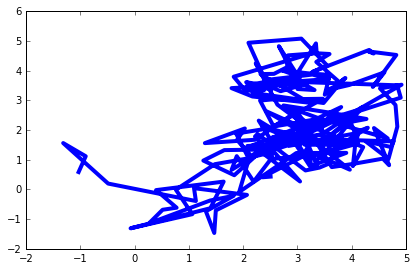

In [33]:
import copy
from math import ceil,log
def create_random_alpha(N,alpha=0.5,drift=[0,0,0],ndim=2):
    coord = []
    hurstExponent = alpha / 2.

    L = int(ceil(log(N)/log(2)))


    scaleFactor = 2 ** (2.0 * hurstExponent)

    def curve2D(t0, x0,y0, t1, x1,y1, variance, scaleFactor):
        if (t1 - t0) < .01:
            #print 
            #stddraw.line(x0, y0, x1, y1)
            coord.append([t1,x1,y1])
            return #[x0, y0] ,[x1, y1]
        tm = (t0 + t1) / 2.0
        ym = (y0 + y1) / 2.0
        xm = (x0 + x1) / 2.0
        deltax = np.random.normal(0, math.sqrt(variance))
        deltay = np.random.normal(0, math.sqrt(variance))

        curve2D(t0,x0, y0, tm, xm+deltax,ym+deltay, variance/scaleFactor, scaleFactor)
        curve2D(tm,xm+deltax, ym+deltay, t1,x1, y1, variance/scaleFactor, scaleFactor)

        
    def curve3D(t0, x0,y0,z0 ,t1, x1,y1,z1, variance, scaleFactor):
        if (t1 - t0) < .01:
            #print 
            #stddraw.line(x0, y0, x1, y1)
            coord.append([t1,x1,y1,z1])
            return #[x0, y0] ,[x1, y1]
        tm = (t0 + t1) / 2.0
        ym = (y0 + y1) / 2.0
        xm = (x0 + x1) / 2.0
        zm = (z0 + z1) / 2.0

        deltax = np.random.normal(0, math.sqrt(variance))
        deltay = np.random.normal(0, math.sqrt(variance))
        deltaz = np.random.normal(0, math.sqrt(variance))

        curve3D(t0,x0, y0,z0 ,tm, xm+deltax,ym+deltay,zm+deltaz, variance/scaleFactor, scaleFactor)
        curve3D(tm,xm+deltax, ym+deltay,zm+deltaz, t1,x1, y1,z1, variance/scaleFactor, scaleFactor)


    scale_step = 8.5
    if ndim == 2:
        curve2D(0., 0.,0., L,0.+drift[0], 0.0+drift[1], scale_step, scaleFactor)
    if ndim == 3:
        curve3D(0., 0.,0.,0, L,0.+drift[0], 0.0+drift[1], 0.0+drift[2], scale_step, scaleFactor)

    #print L
    return np.array(coord)[:N,1:]

if __name__ == "__main__":
    coord = []
    
    def curve(t0, y0, t1, y1, variance, scaleFactor):
        if (t1 - t0) < .01:
            #print 
            #stddraw.line(x0, y0, x1, y1)
            coord.append([t1,y1])
            return #[x0, y0] ,[x1, y1]
        tm = (t0 + t1) / 2.0
        ym = (y0 + y1) / 2.0
        delta = np.random.normal(0, math.sqrt(variance))
        curve(t0, y0, tm, ym+delta, variance/scaleFactor, scaleFactor)
        curve(tm, ym+delta, t1, y1, variance/scaleFactor, scaleFactor)
        

    #-----------------------------------------------------------------------

    # Accept a Hurst exponent as a command-line argument.
    # Use the Hurst exponent to compute a scale factor.
    # Draw a Brownian bridge from (0, .5) to (1.0, .5) with
    # variance .01 and that scale factor.

   
    #curve(0, .5, 25, .5, .01, scaleFactor)
    #coord = np.array(coord)
    #plot(coord[::,0],coord[::,1])
    
    coord = np.array(create_random_alpha(1025,alpha=0.5))
    print coord.shape

    plot(coord[:200,0],coord[:200,1])
    #plot(coord[::,1])
    print (coord[1:,1]-coord[:-1,1]).std()
    
    
    

7.0

In [7]:
import random
import math
import copy
import types
import numpy
import numpy as np
#from matplotlib.axis import axis
"""
print [ k for k in lic2[ch-1].keys() if "x" in k]
with open("/home/jarbona/Theano/subd","w" ) as f:
    gene = "MeancentroMid"
    x,y,z = lic2[ch-1]["x"+gene],lic2[ch-1]["y"+gene],lic2[ch-1]["z"+gene]
    print len(x)
    cPickle.dump([x,y,z],f)

"""




def random_distr(l):
    r = random.uniform(0, 1)
    s = 0
    for item, prob in enumerate(l):
        s += prob
        if s >= r:
            return item
    return item 
    
class HMC:
    """
    Generate markov chain
    """
    def __init__(self):
        self.list_state = ["start","end"]
        self.transition = None
    def add_state(self,sname):
        self.list_state.append(sname)

    def add_transition(self,sn1,sn2,v):

        if self.transition is None:
            self.transition = np.zeros((len(self.list_state),len(self.list_state)))

        self.transition[self.list_state.index(sn1),self.list_state.index(sn2)] = v
    def get_transition(self,sn1,sn2):
        return self.transition[self.list_state.index(sn1),self.list_state.index(sn2)] 

    def sample(self,time,noEnd=True):
        
        end = True
        while end:
            seq = ["start"]
            for i in range(time+1):
                nextt = random_distr(self.transition[self.list_state.index(seq[-1]),::])
                seq.append(self.list_state[nextt])
            
            if "end" in seq and noEnd:
                end = True
            else:
                end = False
            
                
        return seq[1:]



class MotionGenerator:
    def __init__(self,time,ndim,parameters,generate_motion,scales,constraint=[],continuous=False,):
        self.time = time
        self.ndim = ndim
        self.parameter_list = parameters
        self.generate_motion = generate_motion
        self.scales = scales
        self.continuous = continuous
        self.traj_generated
        
    def generate_trajectories(self,n):
        scale = np.random.rand() * self.scales[self.traj_generated]
        self.trajectories = [self.generate_motion(p * scale,self.ndim,self.time+1) for p in self.parameter_list[:n] ]
        self.trajectories = [it[1:]-it[:-1] for it in self.trajectories ]
        self.time_by_traj = [0 for p in self.parameter_list ]
        self.traj_generated += 1
        
    def n_step(self,istate,n,last_step=""):
        
        c = self.trajectories[istate][self.time_by_traj[istate]:self.time_by_traj[istate]+n]
        self.time_by_traj[istate] += n
        
        if self.continuous and last_step != "":
            c = np.sum(last_step**2)**0.5*(c/np.sum(c[0]**2)**0.5)
        return c


class GenerateTraj:
    def __init__(self,time,list_max_possible=[3,3],n_max=5,list_generator=[],
                 lower_selfprob=0.4,fixed_self_proba=False,):
        
        
        self.time = time
        self.n_states = np.random.randint(1,n_max+1)
        
        
        #generate list of possible state
        self.flat_list = ["%i"%(ni) for ni,i in enumerate(list_max_possible) for j in range(i)]
        self.list_state = []
        for i in range(self.n_states):
            self.list_state.append(self.flat_list.pop(np.random.randint(0,len(self.flat_list))))
        self.list_state.sort()
        self.n_list_state = []
        for n in range(len(list_max_possible)):
            if str(n) in self.list_state:
                self.n_list_state.extend(["%i_%i"%(n,j) for j in range(self.list_state.count(str(n)))])
                
        #Initiate model with list of possible state
        selfprob = lower_selfprob + (1-lower_selfprob)*random.random()
        if fixed_self_proba:
            selfprob = lower_selfprob
            
        self.initiate_model(selfprob)
        self.sequence  = self.model.sample(time-1)
                
            

        all_states = list(set(self.sequence))
        all_states.sort()
        
        #Relabel for missing states
        table = [["%i_%i"%(ni,j) for j in range(i) if "%i_%i"%(ni,j) in all_states] for ni,i in enumerate(list_max_possible) ]
   

        translate_table = {}
        for it,t in enumerate(table):
            for n in range(len(t)):
                translate_table[t[n]] = "%i_%i"%(it,n) 

        self.sequence = [translate_table[seq] for seq in self.sequence]
        
        # Generate the trajectories for the states needed
        nn = [istate.split("_")[0] for istate in all_states]
        for n in range(len(list_generator)):
            list_generator[n].generate_trajectories(nn.count(str(n)))
        
        self.traj= []
        t0,istate0 = map(int,self.sequence[0].split("_"))
        n = 1
        for seq in self.sequence[1:]:
            t,istate = map(int,seq.split("_"))
            if t == t0 and istate == istate0:
                n += 1
            else:
                ll = list_generator[t0].n_step(istate0,n,last_step = "" if self.traj == [] else self.traj[-1])
                self.traj.extend(ll)
                t0 = t
                istate0 = istate
                n = 1
        if n != 0:
            ll = list_generator[t0].n_step(istate0,n,last_step = "" if self.traj == [] else self.traj[-1])
            self.traj.extend(ll)
        
        self.traj = np.array(self.traj)
        
        startc = [np.zeros_like(self.traj[0])]
       
        self.traj = np.cumsum(np.concatenate((startc,self.traj)),axis=0)
        
        
    def initiate_model(self,selfprob):    
        
        model  = HMC()
        for state in self.n_list_state:
            model.add_state(state)

        endp=0.0000001
        for state0 in self.n_list_state:
            for state1 in self.n_list_state:
                if state1 == state0:
                    s0=0.166
                    s0=selfprob
                    model.add_transition(state0, state1,s0)
                else:
                    model.add_transition(state0,state1, (1-s0-endp)/(len(self.n_list_state)-1) )


        for state in self.n_list_state:

            model.add_transition("start",state, 1.0/len(self.n_list_state))
            model.add_transition(state,"end", endp)

        self.model = model
        

        
if __name__ == "__main__":
    time=100
    ndim=2
    list_generator = [MotionGenerator(time,ndim,
                                      parameters=np.random.rand(3),
                                      generate_motion=diffusive,
                                      scales=[1,10]),
                      MotionGenerator(time,ndim,
                                      parameters=np.random.rand(3),
                                      generate_motion=accelerated,continuous=True,scales=[1,10])]

    A = GenerateTraj(100,list_max_possible=[2,1],n_max=2,list_generator=list_generator)
    """
    print A.n_states
    print A.flat_list
    print A.list_state
    print A.n_list_state
    print A.sequence
    print A.traj,A.sequence"""
    print (len(A.traj), len(A.sequence))
    from Tools import plot_label

    def map_sequence(sequence):
        ns = []
        for iseque in  sequence:
            i0,j0 = map(int,iseque.split("_"))
            ns.append(i0*3+j0)
        print( ns)
        return ns
    print (np.sum((A.traj[1:]-A.traj[:-1])**2,axis=1)**0.5)
    plot_label(A.traj,map_sequence(A.sequence))

NameError: name 'diffusive' is not defined

In [329]:
if __name__ == "__main__":


    M = one_particle_n_states_s([0,1])
    print M.transition
    print M.list_state
    print M.get_transition("end","start")
    print M.sample(3)

[[  0.00000000e+00   0.00000000e+00   5.00000000e-01   5.00000000e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-07   3.30000000e-02   9.66999900e-01]
 [  0.00000000e+00   1.00000000e-07   9.66999900e-01   3.30000000e-02]]
['start', 'end', 'Ra0', 'Ra1']
0.0
['Ra1', 'Ra0', 'Ra1', 'Ra0']


In [345]:
def fractional_1D(size,H):
    #numpy.random.seed(0)
    N = size
    HH = 2*H
    covariance = numpy.zeros((N,N))
    I = numpy.indices((N,N))

    covariance = abs(I[0]-I[1])
    covariance = (abs(covariance - 1)**HH + (covariance + 1)**HH - 2*covariance**HH)/2.
    
    
    w,v = numpy.linalg.eig(covariance)
    ws = w  **0.25
    v = ws[newaxis,::] * v
    A = np.inner(v,v)
    x = numpy.random.randn((N))
    eta = numpy.dot(A,x)
    xfBm = np.cumsum(eta)
    return np.concatenate([[0],xfBm])

def fractional_1D_slow(size,H):
    #numpy.random.seed(0)
    N = size
    HH = 2*H
    numpy.random.seed(0)
    covariance = numpy.zeros((N,N))
    A = numpy.zeros((N,N))
    for i in range(N):
        for j in range(N):
            d = abs(i-j)
            covariance[i,j] = (abs(d - 1)**HH + (d + 1)**HH - 2*d**HH)/2.
    w,v = numpy.linalg.eig(covariance)
    for i in range(N):
        for j in range(N):
            A[i,j] = sum(math.sqrt(w[k])*v[i,k]*v[j,k] for k in range(N))
    x = numpy.random.randn((N))
    eta = numpy.dot(A,x)
    return np.array([sum(eta[0:i]) for i in range(len(eta)+1)])
    
if __name__ == "__main__":
    print np.sum(fractional_1D(200,0.25)-fractional_1D_slow(200,0.25))
    #%timeit fractional_1D(200,1)
    #%timeit fractional_1D_slow(200,0.5)


-1612.56390071


In [103]:
def in_sphere(X,R):
    #print X <= R
    if np.all(X <= R) and np.sum(X**2) <= R**2:
        return True
    return False
def reflect(X,dX):
    norm = np.sum(X**2)**0.5
    norm = X/norm
    parallel = np.sum(norm * dX) * norm
    #print parallel
    return dX-2*parallel


In [35]:
import scipy
def diffusive(scale,ndim,time,epsilon=1e-7):
        
    mus1 = np.zeros((ndim))
    rho1 = np.random.random(1+(ndim-2)*2) + epsilon
    sigmas1 = scale*np.random.random(1) + epsilon


    cov = sigmas1 * np.eye(ndim) + epsilon
    traj = np.cumsum(numpy.random.multivariate_normal(mus1,cov,time),axis=0)
    alpha = 2*3.14 * np.random.rand()

    return random_rot(traj,alpha,ndim)[:time]

def diffusive_confined(scale,ndim,time,epsilon=1e-7):
        
    mus1 = np.zeros((ndim))
    rho1 = np.random.random(1+(ndim-2)*2) + epsilon
    sigmas1 = scale*np.random.random(1) + epsilon


    cov = sigmas1 * np.eye(ndim) + epsilon
    anisentropy = 0.2* np.random.rand()
    cov[1,1] *= anisentropy
    traj = np.cumsum(numpy.random.multivariate_normal(mus1,cov,time),axis=0)
    alpha = 2*3.14 * np.random.rand()

    return random_rot(traj,alpha,ndim)[:time]

def directed(scale,ndim,time,epsilon=1e-7,delta_sigma_directed=6):
        
    mus1 = scale*(1-2*np.random.random(ndim))
    rho1 = np.random.random(1+(ndim-2)*2) + epsilon
    sigmas1 = scale*np.random.random(ndim) + epsilon

    d1 = np.sqrt(np.sum(mus1**2))+epsilon
    if d1 < 0.01:
        mus1 = 0.01*mus1/d1
        
    for indim in range(ndim):
        sigmas1[indim]  = min(d1/delta_sigma_directed,sigmas1[indim])
        
    if ndim == 2:
        scf = 2**0.5
        def get_covariance(sigmasm,rhom):
            return [[sigmasm[0] * scf, sigmasm[0]*sigmasm[1]*rhom[0] * scf],
                           [sigmasm[0]*sigmasm[1]*rhom[0] * scf, sigmasm[1] * scf]]
        
    if ndim == 3:
        scf = 2**0.5
        def get_covariance(sigmasm,rhom):
            return [[sigmasm[0] * scf, sigmasm[0]*sigmasm[1]*rhom[0] * scf, sigmasm[0]*sigmasm[2]*rhom[1] * scf],
                    [sigmasm[0]*sigmasm[1]*rhom[0] * scf, sigmasm[1] * scf,  sigmasm[1]*sigmasm[2]*rhom[2] * scf],
                    [sigmasm[0]*sigmasm[2]*rhom[1] * scf, sigmasm[1]*sigmasm[2]*rhom[2] * scf, sigmasm[2] * scf]]
        
        
    cov = get_covariance(sigmas1,rho1)
    traj =  np.cumsum(numpy.random.multivariate_normal(mus1,cov,time),axis=0)
    alpha = 2*3.14 * np.random.rand()

    return random_rot(traj,alpha,ndim)[:time]

def accelerated(scale,ndim,time,epsilon=1e-7,delta_sigma_directed=6):
        
    mus1 = scale*(1-2*np.random.random(ndim))
    rho1 = np.random.random(1+(ndim-2)*2) + epsilon
    sigmas1 = scale*np.random.random(ndim) + epsilon
    
    accelerated = 2+2*np.random.rand()

    d1 = np.sqrt(np.sum(mus1**2))+epsilon
    if d1 < 0.01:
        mus1 = 0.01*mus1/d1
        
    for indim in range(ndim):
        sigmas1[indim]  = min(d1/delta_sigma_directed,sigmas1[indim])
        
    if ndim == 2:
        scf = 2**0.5
        def get_covariance(sigmasm,rhom):
            return [[sigmasm[0] * scf, sigmasm[0]*sigmasm[1]*rhom[0] * scf],
                           [sigmasm[0]*sigmasm[1]*rhom[0] * scf, sigmasm[1] * scf]]
        
    if ndim == 3:
        scf = 2**0.5
        def get_covariance(sigmasm,rhom):
            return [[sigmasm[0] * scf, sigmasm[0]*sigmasm[1]*rhom[0] * scf, sigmasm[0]*sigmasm[2]*rhom[1] * scf],
                    [sigmasm[0]*sigmasm[1]*rhom[0] * scf, sigmasm[1] * scf,  sigmasm[1]*sigmasm[2]*rhom[2] * scf],
                    [sigmasm[0]*sigmasm[2]*rhom[1] * scf, sigmasm[1]*sigmasm[2]*rhom[2] * scf, sigmasm[2] * scf]]
        
        
    cov = get_covariance(sigmas1,rho1)
      
    acc = np.random.rand()*numpy.random.multivariate_normal(mus1,cov,time) + \
            mus1 /accelerated * np.array([np.arange(time),np.arange(time),np.arange(time)]).T[::,:ndim]
        
    maxi =  np.max(np.sum(acc**2,axis=1)**0.5)
    acc = acc * scale /maxi
        
    return np.cumsum(acc,axis=0)

def slowed(scale,ndim,time,epsilon=1e-7,delta_sigma_directed=6):
    
    return accelerated(scale,ndim,time,epsilon,delta_sigma_directed)[::-1]

def still(scale,ndim,time,epsilon=1e-7,delta_sigma_directed=6):
    
    return np.zeros((time,ndim))

def sinusoidal(scale,ndim,time,epsilon=1e-7):
        
    period = np.random.rand()
    sample_rate = np.random.randint(5,10)
    
    t = np.arange(time)
    traj = np.array([scale * t, scale* np.sin(2*3.14*period*t/sample_rate),np.zeros_like(t)]).T
      
    alpha = 2*3.14 * np.random.rand()
    
    if ndim == 2:
        traj = traj[::,:2]
                
        
    noise = diffusive(scale/4.,ndim,time+1,epsilon=1e-7)
    return random_rot(traj,alpha,ndim) + noise[:-1]-noise[1:]
    

def heart(scale,ndim,time):
    
    
    percent = 1.05 + 0.5*np.random.rand()
    
    real_heart = int(time*percent)
    
    ratio = 0.5*np.random.rand()  #xy ratio
    x = scipy.linspace(-2,2,real_heart/2)
    y1 = scipy.sqrt(1-(abs(x)-1)**2)
    y2 = -3*scipy.sqrt(1-(abs(x[::-1])/2)**0.5)
    
    Y = np.concatenate([y1,y2])
    X  = ratio*np.concatenate([x,x[::-1]])
    
    shift = np.random.randint(0,real_heart)
    Y = np.roll(Y,shift)[:time]
    X = np.roll(X,shift)[:time]
    traj = np.array([X,Y,np.zeros_like(Y)]).T
    
    alpha = 2*3.14 * np.random.rand()
    
    if ndim == 2:
        traj = traj[::,:2]
                    
   
    
    noise = diffusive(scale/800.,ndim,time+1,epsilon=1e-7)
    return scale*random_rot(traj,alpha,ndim) + noise[:-1]-noise[1:]

def subdiffusive_confined(scale,ndim,time):
    alpha = 0.5
    traj = create_random_alpha(time+1,alpha=alpha,ndim=ndim)
    anisentropy = 0.2* np.random.rand()
    traj[::,1] *= anisentropy
    alpha = 2*3.14 * np.random.rand()
    
    return scale*random_rot(traj,alpha,ndim)[:time]
def continuous_time_random_walk(scale,ndim,time):
    alpha= 2 +np.random.rand()
    s=time
    x= np.zeros((s))
    y= np.zeros((s))
    t = 0
    while t < time:
        alpha = 1
        dt=0.01*np.power(1-np.random.rand(),-1/alpha)

        t += dt
        theta=np.random.rand()*2*np.pi
        
        if int(t) >= time:
            break
        x[int(t)] += np.random.normal(0,1)
        y[int(t)] += np.random.normal(0,1)
        if int(t) < time -1 :
            x[int(t+1):] = x[int(t)]
            y[int(t+1):] = y[int(t)]

            
    coord = np.array([x,y]).T
    alpha = 2*3.14 * np.random.rand()

    return scale*coord

def continuous_time_random_walk_confined(scale,ndim,time):
    alpha= 2 +np.random.rand()
    s=time
    x= np.zeros((s))
    y= np.zeros((s))
    t = 0
    while t < time:
        alpha = 1
        dt=0.01*np.power(1-np.random.rand(),-1/alpha)

        t += dt
        theta=np.random.rand()*2*np.pi
        
        if int(t) >= time:
            break
        x[int(t)] += np.random.normal(0,1)
        y[int(t)] += np.random.normal(0,1)
        if int(t) < time -1 :
            x[int(t+1):] = x[int(t)]
            y[int(t+1):] = y[int(t)]

    anisentropy = 0.2* np.random.rand()
    coord = np.array([x,y*anisentropy]).T
    alpha = 2*3.14 * np.random.rand()

    return scale*random_rot(coord,alpha,ndim)[:time]

def subdiffusive(scale,ndim,time):
   alpha = 0.5
   traj = create_random_alpha(time+1,alpha=alpha,ndim=ndim)

   alpha = 2*3.14 * np.random.rand()
   return scale*random_rot(traj,alpha,ndim)[:time]

def levi_flight(scale,ndim,time):
    alpha= 2 +np.random.rand()
    s=time
    x= np.zeros((s))
    y= np.zeros((s))
    for n in range(1,s):
        theta=np.random.rand()*2*np.pi
        f=np.random.rand()**(-1/alpha)
        x[n]=x[n-1]+f*np.cos(theta)
        y[n]=y[n-1]+f*np.sin(theta)
    
    coord = np.array([x,y]).T
    return scale*coord

def fractionnal_brownian(scale,ndim,time):
    alpha = 0.25
    traj = np.array([fractional_1D(time,alpha) for d in range(ndim)]).T

    alpha = 2*3.14 * np.random.rand()
    return scale*random_rot(traj,alpha,ndim)[:time]

def brownian_confined_on_plane(scale,ndim,time):
    
    traj = diffusive(scale,2,time)
    traj = np.concatenate((traj,np.zeros((traj.shape[0],1))),axis=1)

    return random_rot(traj,ndim=3)[:time,:ndim]


def sub_confined_on_plane(scale,ndim,time):
    
    traj = subdiffusive(scale,2,time)
    traj = np.concatenate((traj,np.zeros((traj.shape[0],1))),axis=1)

    return random_rot(traj,ndim=3)[:time,:ndim]
    
def sub_confined_on_plane_0p7(scale,ndim,time,p=0.7):
    
    #p = 0.5 + 0.2 * np.random.rand()

    
    traj = subdiffusive(scale,3,time+1)

    to_cut = range(len(traj) - 1) 
    N = int(len(to_cut) * p )
    np.random.shuffle(to_cut)

    dtraj = traj[1:]-traj[:-1]
    dtraj[to_cut[:N],2]= 0
    
    traj = np.cumsum(dtraj,axis=0)
    return random_rot(traj,ndim=3)[:time,:ndim]

def brownian_confined_on_plane_0p7(scale,ndim,time,p=0.7):
    
    #p = 0.5 + 0.2 * np.random.rand()
    
    traj = diffusive(scale,3,time+1)

    to_cut = range(len(traj) - 1) 
    N = int(len(to_cut) * p )
    np.random.shuffle(to_cut)

    dtraj = traj[1:]-traj[:-1]
    dtraj[to_cut[:N],2]= 0
    
    traj = np.cumsum(dtraj,axis=0)
    return random_rot(traj,ndim=3)[:time,:ndim]

def min_contact(ncontact):
    def dec1(func):
        #print "Min contact",ncontact
        def wrapper(*args,**kwargs):
            kwargs["contact"] = True
            response = [0,0]
            while response[1] < max(1,ncontact):
                response = func(*args,**kwargs)
            
            return response[0]
        return wrapper
    return dec1
    
@min_contact(10)
def brownian_confined_in_sphere(scale,ndim,time,show=False,contact=True):
    
    traj = diffusive(scale,ndim,time+1)
    delta = traj[1:]-traj[:-1]
    
    R = (0.2+0.6*np.random.rand() ) * scale* np.sqrt(time)
    #New 0.3 + 0.1
    #before 0.2 + 0.6
    #print R
    ftraj = [np.zeros((traj.shape[1]))]
    n_contact = 0
    for v in delta:
        #print v
        if in_sphere(ftraj[-1] + v,R):
            ftraj.append(ftraj[-1]+v)
        else:
            n_contact += 1
            r = reflect(ftraj[-1],v)
            #print r,v
            ftraj.append(ftraj[-1]+r)
    if show:
        print n_contact
    traj = np.array(ftraj)
    if contact:
        return random_rot(np.array(traj),ndim=ndim)[:time,:ndim],n_contact
    else:
        return random_rot(np.array(traj),ndim=ndim)[:time,:ndim]



@min_contact(10)
def sub_confined_in_sphere(scale,ndim,time,show=False,contact=True):
    
    traj = subdiffusive(scale,ndim,time+1)
    delta = traj[1:]-traj[:-1]
    
    
    R = (0.9+0.4*np.random.rand() ) * scale* (1.0*time)**0.33
    R = (1.4+1.0*np.random.rand() ) * scale* (1.0*time)**(0.15+0.5/(time-20))

    #print R
    ftraj = [np.zeros((traj.shape[1]))]
    n_contact = 0
    for v in delta:
        #print v
        if in_sphere(ftraj[-1] + v,R):
            ftraj.append(ftraj[-1]+v)
        else:
            n_contact += 1
            r = reflect(ftraj[-1],v)
            #print r,v
            ftraj.append(ftraj[-1]+r)
    
    if show:
        print "N_contact", n_contact
    traj = np.array(ftraj)
    if contact :
        return random_rot(np.array(traj),ndim=ndim)[:time,:ndim], n_contact
    else:
        return random_rot(np.array(traj),ndim=ndim)[:time,:ndim]



    
def generate_traj_general():
    pass

if __name__ == "__main__":
    """
    print sinusoidal(1,2,10).shape
    
    #X = sinusoidal(1,3,200)
    #plot(X[::,0],X[::,1])
    
    X = sub_confined_in_sphere(1,3,400,show=True)
   
    #X = brownian_confined_on_plane_0p7(1,3,40)
    #for i in range(10):
    #     brownian_confined_in_sphere(1,3,40,show=True)
    
    #X = fb_confined_in_sphere(1,2,400)

    print X.shape
    
    plot(X[::,0],X[::,2],"-o")"""

(100, 2)


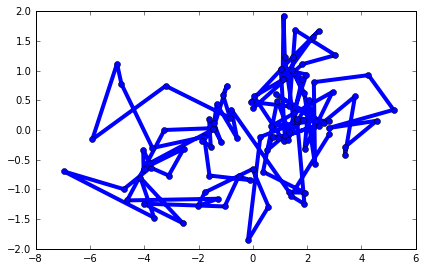

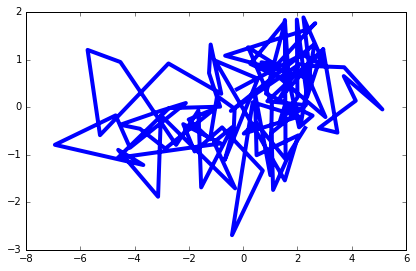

In [18]:
if __name__ == "__main__":
    ndim=2
    X = sub_confined_on_plane(1,2,100)
    
    #X = fb_confined_in_sphere(1,2,400)

    print X.shape
    
    plot(X[::,0],X[::,1],"-o")

    
    figure()
    
    noise = diffusive(0.4,ndim,len(X)+1,epsilon=1e-7)
    
    dn =  noise[:-1]-noise[1:]
    plot(X[::,0]+dn[::,0],X[::,1]+dn[::,1])

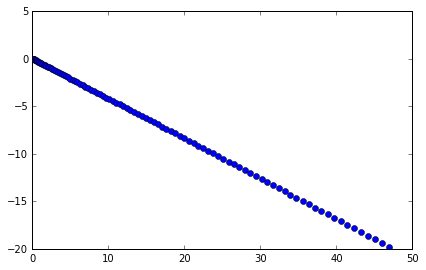

In [284]:
if __name__ == "__main__":
    t = accelerated(1,time=100,ndim=2)
    plot(t[::,0],t[::,1],"o")
    #print X
    #dot(axis.T,newtraj).T
    #axis = M([1,0,0],np.pi /2)

In [18]:
#down_grade
#%timeit( generate_traj(200,fight=False,sub=True,force_model=20,clean=4) , 10)
#print 0.37/0.3

if __name__ == "__main__":
    #print X.std()
    print np.sqrt(0.5)
    for i in range(10):
        #5 or 18
        ModelN,Model_num,s,sc,traj,normed,alpha2  = generate_traj(400,fight=False,sub=True,
                                                                  force_model=18,clean=4,
                                                                  check_delta=True,diff_sigma=1.1,Ra0=[0,1.]) 
        #print traj.shape
        #traj = np.concatenate((traj,traj[::,0:1]),axis=1)
        #print traj.shape
        print [[ig[0],ig[2][2]**0.5] for ig in get_parameters(traj,sc,1,1)]

0.707106781187
{'sRa0': [0, 0.4826774869790812], 'sRa1': [0, 1.0786432544986648], 'sRa2': [0, 2.41527979075941]}
[[6.0, 0.11337994607742534], [7.0, 0.3563611079236898], [8.0, 0.74326722892427621]]
{'sRa0': [0, 0.45570889108304], 'sRa1': [0, 1], 'sRa2': [0, 2.4825189629278848]}
[[6.0, 0.13447275594332544], [7.0, 0.2567994101507397], [8.0, 0.48560927100408652]]
{'sRa0': [0, 0.6747595240248546], 'sRa1': [0, 1.4786106218632895], 'sRa2': [0, 3.9209640501194762]}
[[6.0, 0.19951755954881847], [7.0, 0.27787638821444149], [8.0, 1.253007798506947]]
{'sRa0': [0, 0.5455530086801429], 'sRa1': [0, 1.9782688934353407], 'sRa2': [0, 4.198102813241563]}
[[6.0, 0.14403720938017434], [7.0, 0.40804605727017196], [8.0, 0.85183039384329273]]
{'sRa0': [0, 0.4795049272286156], 'sRa1': [0, 1.7649646885995416], 'sRa2': [0, 3.6640571518467318]}
[[6.0, 0.17988702951617874], [7.0, 0.47440562877815246], [8.0, 0.625125525364708]]
{'sRa0': [0, 0.22412122826551628], 'sRa1': [0, 1.430216917302484], 'sRa2': [0, 2.9313447

In [343]:
def MSD(Coords,skip=10,stop=1000,nonOverlap=True):
    #print "MSD doing the calc"
    end = len(Coords[0])
    deb=0
    stop=stop
    indep=2000
    skip = skip
    #nonOverlap=True

    msd = np.zeros(end-deb-stop)
    for k in range(1,end-deb-stop,skip):
        n = 0
        if nonOverlap:
            indep = 0 + k
        else:
            indep = 1
        for i in range(0,end-k-deb,indep):
            start = Coords[::,i]
            pos = Coords[::,i+k]
#            import pdb
#            pdb.set_trace()
            msd[k] += np.sum((start-pos)**2)
            n += 1

        msd[k]  =  msd[k]  /n
    return msd[1::skip]

In [738]:
if __name__ == "__main__":
    lm = [diffusive,directed,accelerated,heart,sinusoidal,fractionnal_brownian]
    lm += [brownian_confined_in_sphere,brownian_confined_on_plane,fb_confined_in_sphere,fb_confined_on_plane]
    lm += [subdiffusive]
    M2 = ["diff","direct","accel","heart","sinus","frac","b_sphep","B_plane","fb_sphere","fb_plane","sub"]

    for f,n in zip(lm,M2):
        print n
        %timeit f(1,3,400)

diff
The slowest run took 4.94 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 235 µs per loop
direct
1000 loops, best of 3: 262 µs per loop
accel
1000 loops, best of 3: 295 µs per loop
heart
1000 loops, best of 3: 670 µs per loop
sinus
1000 loops, best of 3: 591 µs per loop
frac
1 loops, best of 3: 956 ms per loop
b_sphep
100 loops, best of 3: 7.36 ms per loop
B_plane
1000 loops, best of 3: 524 µs per loop
fb_sphere
1 loops, best of 3: 974 ms per loop
fb_plane
1 loops, best of 3: 642 ms per loop
sub
1000 loops, best of 3: 1.72 ms per loop


[[-0.89899734  0.07849611  0.43086209]
 [ 0.38022766 -0.34830295  0.85680335]
 [ 0.21732626  0.93408962  0.28327703]]
[ 0.99201064  0.35664609]
(398,)


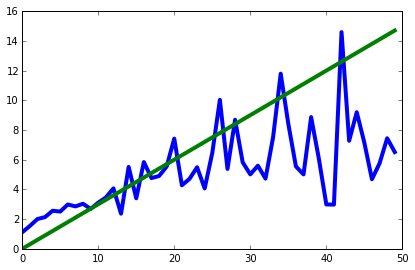

In [599]:
if __name__ == "__main__":
    from mpl_toolkits.mplot3d import Axes3D

    coord = fb_confined_on_plane(1,2,400)
    #coord = fractionnal_brownian(1,2,400)
    #coord = diffusive(1,3,400)
    
        
    print np.std(coord[1:]-coord[:-1],axis=0)
    msd = MSD(coord[::,:].T,stop=1,skip=1)
    print msd.shape
    
    plot(msd[:50])
    plot(np.arange(50),0.3*np.arange(50))
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    #scatter(coord[::,0],coord[::,1],coord[::,2])
    #axis("equal")

In [627]:
if __name__ == "__main__":
    def timeE():
        ModelN,Model_num,s,sc,real_traj,norm,Z = generate_traj(100,sub=True,clean=4,diff_sigma=1.1,ndim=3)


        alpharot = 2*3.14*np.random.random()

        real_traj  = random_rot(real_traj,alpharot,ndim=3)

        alligned_traj,normed,alpha,_ = traj_to_dist(real_traj,ndim=3)
        
    def timeM():
        StateN = {"Ra0": 0,"Ra1":1,"Ra2":2,"Le0":3,"Ri0":4,"Ri1":5,"sRa0":6,"sRa1":7,"sRa2":8}#,"Ra3": 3,"Ra4":4,"Ra5":5,"Le0":6}
        ListState = [0,1,3,5]
        model = one_particle_n_states(ListState0=ListState,StateN=StateN,selfprob=0.4)
        sequence  = model.sample(100)
        for i in sequence:
            pass

        #model.sequence

    %time timeE()
    #%prun??
    #%prun -s cumulative timeM()
    #%timeit np.random.multivariate_normal([0,0],[[1,0.1],[1,0]],10)

/home/jarbona/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:356: RuntimeWarning: covariance is not positive-semidefinite.


NameError: global name 'traj_to_dist' is not defined